### 思路
1. 数据处理，构造数据集
    - 文本：K个常见ans
    - 图像：
- 模型
    - image：resize->cnn->fc_1024
    - question：embedding->fc_1024
    - concat or add->fc_K->交叉熵


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import numpy as np
import random
from time import time

SEED = 1234
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    torch.cuda.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
import json
with open('./dataset/mscoco_val2014_annotations.json') as f1, open('./dataset/MultipleChoice_mscoco_val2014_questions.json') as f2:
    annotations = json.load(f1)
    questions = json.load(f2) 

# with open('./dataset/v2_mscoco_val2014_annotations.json') as f1, open('./dataset/v2_OpenEnded_mscoco_val2014_questions.json') as f2:
#     annotations = json.load(f1)
#     questions = json.load(f2) 
# with open('./dataset/OpenEnded_mscoco_val2014_questions.json') as f:
#     question = json.load(f)

[解析JSON](https://python3-cookbook.readthedocs.io/zh_CN/latest/c06/p02_read-write_json_data.html)，先观察数据

官方API中vqaTools demo：

In [3]:
from vqaTool import VQA

dataDir		='./dataset'
versionType ='' # this should be '' when using VQA v2.0 dataset
taskType    ='MultipleChoice' # 'OpenEnded' only for v2.0. 'OpenEnded' or 'MultipleChoice' for v1.0
dataType    ='mscoco'  # 'mscoco' only for v1.0. 'mscoco' for real and 'abstract_v002' for abstract for v1.0.
dataSubType ='val2014'
annFile     ='%s/%s%s_%s_annotations.json'%(dataDir, versionType, dataType, dataSubType)
quesFile    ='%s/%s%s_%s_%s_questions.json'%(dataDir, versionType, taskType, dataType, dataSubType)
# imgDir 		= '%s/Images/%s/%s/' %(dataDir, dataType, dataSubType)
img_dir = '%s/Images/%s/' %(dataDir, dataSubType)

In [4]:
ann = annotations['annotations'][:]
ques = questions['questions'][:]
print('num of ques:', len(ques))

QUES_N = len(ques) 
ANS_K = 999 #最常见的ans数

num of ques: 121512


In [5]:
display(ann[5])
display(ques[5])

{'answer_type': 'other',
 'answers': [{'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'tree', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 8647,
 'multiple_choice_answer': 'tree',
 'question_id': 86471,
 'question_type': 'what is in the'}

{'image_id': 8647,
 'multiple_choices': ['red',
  '4',
  '2',
  '1',
  'berries and cake',
  'light',
  'no',
  'sun',
  'white',
  'yes',
  'green',
  '1.50',
  'mayonnaise',
  '3',
  'blue',
  'tree',
  'stamp',
  'on feet'],
 'question': 'What is in the top right corner?',
 'question_id': 86471}

### 构造数据集
做完基本处理后放dataloader里，可以并行  
**（1）处理文本**

In [6]:
#提取ques ans imgId
from collections import Counter
ground_truth_trainset = []
ques_trainset = []
img_ids = []

for i in range(QUES_N):
    ground_truth_trainset.append(ann[i]['multiple_choice_answer'])
    ques_trainset.append(ques[i]['question'])
    if i % 3 == 0:
        img_ids.append(ques[i]['image_id'])
        
print('num of images：', len(img_ids))
ans_words = dict(Counter(ground_truth_trainset))
print('num of ans:', len(ans_words))
ans_words_most = dict(Counter(ground_truth_trainset).most_common(ANS_K))#最常见的1000个ans作分类

print(ground_truth_trainset[:3], ques_trainset[:3], img_ids[:1], sep='\n\n')

num of images： 40504
num of ans: 10908
['wood', 'no', 'kettles']

['What is the table made of?', 'Is the food napping on the table?', 'What has been upcycled to make lights?']

[350623]


In [7]:
# import spacy
# nlp = spacy.load('en')
# return nlp.tokenizer(text)

def word_tokenize(text):
    t = [w for w in text.split(' ')]
    t[-1] = t[-1][:-1]
    return t

word2idx = {'UNK':0}
ans2idx = {}
v, v_a = 1, 1

for i in range(QUES_N):
    for w in word_tokenize(ques_trainset[i]):
        if w not in word2idx:
            word2idx[w] = v
            v += 1
    ques_trainset[i] = torch.LongTensor([word2idx[w] for w in word_tokenize(ques_trainset[i])])

for i,w in enumerate(ground_truth_trainset):
    if w not in word2idx:
        word2idx[w] = v
        v += 1
    if w in ans_words_most:
        if w not in ans2idx:
            ans2idx[w] = v_a
            v_a += 1
        ground_truth_trainset[i] = torch.LongTensor([ans2idx[w]])
    
    else:
        ground_truth_trainset[i] = torch.LongTensor([0])
        
print('vocab_size:',v)
print('true num of ans:',v_a)
VOCAB_SIZE = v
idx2word = {i:w for i,w in enumerate(word2idx)}

vocab_size: 19796
true num of ans: 1000


In [8]:
s,m = 0,0
for i,x in enumerate(ques_trainset):
    s+=len(x)
    if len(x)>m:
        m=len(x)
print('句长mean:%f, max:%d'%(s/i, m))


句长mean:6.205726, max:23


** （2）处理图像 **

In [9]:
import matplotlib.pyplot as plt#为什么写到一个框里就不能显示
from PIL import Image
import skimage.io as io
import torchvision.transforms as transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

350623 torch.Size([3, 256, 256])


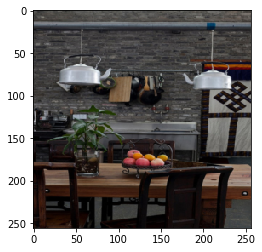

In [10]:
IMG_SIZE = 256
def trans_img(path, size=IMG_SIZE):
    mode = Image.open(path)
    if len(mode.split()) == 3:
        transform1 = transforms.Compose([
            transforms.Resize((size, size)),#确保无黑边
            transforms.CenterCrop((size, size)),
            transforms.ToTensor()
        ])
    else:
        transform1 = transforms.Compose([
            transforms.Resize((size, size)),#确保无黑边
            transforms.CenterCrop((size, size)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()
        ])
    mode = transform1(mode)
    return mode

def show_img(image):
    mode = transforms.ToPILImage()(image)
    plt.imshow(mode)
    plt.show()
    
for img_id in img_ids[:1]:
    img_filename = 'COCO_' + dataSubType + '_'+ str(img_id).zfill(12) + '.jpg'
    img = trans_img(img_dir + img_filename)
    print(img_id, img.shape)
    show_img(img)

**（3）DataLoader**  
后来发现可以写一起

In [11]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

BATCH_SIZE = 1024 # 2:128, 3:92, 4:83, 5/1000:73/76, 50/8:64/66, 
MAX_SEQ_LEN = 23

class VQA_Dataset(Dataset):
    def __init__(self, img_ids, q, a):
        self.img_ids = img_ids
        self.q = q            
        self.a = a
        
    def __len__(self):
        return QUES_N
    
    def __getitem__(self, idx):
        img_filename = 'COCO_' + dataSubType + '_'+ str(img_ids[idx//3]).zfill(12) + '.jpg'
        img = trans_img(img_dir + img_filename)
        Lq = len(self.q[idx])
        if Lq > MAX_SEQ_LEN:
            self.q[idx] = self.q[idx][:MAX_SEQ_LEN]
        elif Lq < MAX_SEQ_LEN:
            self.q[idx] = F.pad(self.q[idx], (0,MAX_SEQ_LEN-Lq))#前后分别补多少
        return img, self.q[idx], self.a[idx]
    
dataset = VQA_Dataset(img_ids=img_ids, q=ques_trainset, a=ground_truth_trainset)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False, num_workers=40)
# return list[img,q,a], img:[b,3,256,256], q:[b,seq], a:[b,1]

### VQA model

In [12]:
EPOCH = 2

class VQA_baseline(nn.Module):
    def __init__(self, embed_dim, fc_dim, out_dim):
        super(VQA_baseline, self).__init__()
        self.embed_dim = embed_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.img_fc = nn.Linear(in_features=10*61*61, out_features=fc_dim)
        
        self.embed = nn.Embedding(VOCAB_SIZE, embed_dim)
        self.ques_fc = nn.Linear(MAX_SEQ_LEN*embed_dim, fc_dim)
        
        self.bn = nn.BatchNorm1d(fc_dim)
        self.fc2ans = nn.Linear(fc_dim, out_dim)
        
    def forward(self, p, q):
        # pic:[b,3,256,256]
        p = self.pool(F.relu(self.conv1(p))) #[b,6,252,252]->[b,6,126,126]
        p = self.pool(F.relu(self.conv2(p))) #[b,10,122,122]->[b,10,61,61]
        p = p.view(-1, 10*61*61) #[b,10*61*61]
        p = self.bn(self.img_fc(p)) #[b,fc_dim]
        
        # ques:[b,seq]
        q = q.view(MAX_SEQ_LEN, -1)#[seq,b]，因为并行时，batch_size会被打开
        q = self.embed(q)#[seq,emb,b]
        q = q.view(-1, MAX_SEQ_LEN * self.embed_dim)
        
        q = self.ques_fc(q)
        q = self.bn(q)#[b,fc_dim]
        
        return self.fc2ans(p+q) #element-wise add, [b,out_dim]
    
    
model = VQA_baseline(embed_dim=300, fc_dim=1024, out_dim=1000)
if USE_CUDA:
    model = model.cuda()
    model = nn.DataParallel(model, device_ids=[0,1,2,3])


loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

t = time()
for epoch in range(EPOCH):
    for i, (img, q, a) in enumerate(dataloader):
        opt.zero_grad()
        if USE_CUDA:
            img,q,a = img.cuda(),q.cuda(),a.cuda()
        
        y = model(img, q)
        loss = loss_fn(y, a.squeeze())
        loss.backward()
        opt.step()
        
        if i%10 == 0:
            print('epoch:',epoch+1,'iter:',i,'loss:',loss.item())
    print(time() - t)


epoch: 1 iter: 0 loss: 7.019451141357422
epoch: 1 iter: 10 loss: 3.3523311614990234
epoch: 1 iter: 20 loss: 3.145465612411499
epoch: 1 iter: 30 loss: 2.883629322052002
epoch: 1 iter: 40 loss: 2.66436505317688
epoch: 1 iter: 50 loss: 2.588735580444336
epoch: 1 iter: 60 loss: 2.6891043186187744
epoch: 1 iter: 70 loss: 2.5475070476531982
epoch: 1 iter: 80 loss: 2.498427629470825
epoch: 1 iter: 90 loss: 2.3418214321136475
epoch: 1 iter: 100 loss: 2.3785505294799805
epoch: 1 iter: 110 loss: 2.302963972091675
350.8975191116333
epoch: 2 iter: 0 loss: 1.7810170650482178
epoch: 2 iter: 10 loss: 2.055971622467041
epoch: 2 iter: 20 loss: 2.275662422180176
epoch: 2 iter: 30 loss: 2.091705083847046
epoch: 2 iter: 40 loss: 2.050320625305176
epoch: 2 iter: 50 loss: 2.034024238586426
epoch: 2 iter: 60 loss: 2.1178219318389893
epoch: 2 iter: 70 loss: 2.044668436050415
epoch: 2 iter: 80 loss: 2.0125112533569336
epoch: 2 iter: 90 loss: 1.8999806642532349
epoch: 2 iter: 100 loss: 1.9490470886230469
epoch:

### evaluation